# EXAM PAPER MARGAUX DELPORTE (r0595384)

My exam paper consists of an analysis of the movie review section of the New York times. This site contains an API that gives access to over 22,000 New York Times movie reviews from today back to 1924. In the first part I create a function to make the search in the API automated. Since the text of the reviews is not included in the API, the second part is scraping the movie reviews pages. A sentiment analysis of a review is included in the third part. The fourth path integrates the previous three parts in one function; when you search for a movie in the API, you get the movie, the text and the sentiment analysis. In the last part I use text mining to predict whether the movie is recommended by the New York times critics or not.


## PART 0: loading the packages in Python

In [1]:
import requests
import pandas as pd
import random
from sklearn.feature_extraction.text import CountVectorizer
from time import sleep
from requests_html import HTMLSession
from afinn import Afinn
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
import numpy as np
import collections
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
from sklearn.model_selection import GridSearchCV

## PART 1: API 

In this part I create a function to make the search in the API easier. In addition, I overcome the issue that the returned dataframe from the API only contains the last page of results. Notice that a key is also necessary, I have obtained it for free from the developer site of the New York Times (https://developer.nytimes.com/indexV2.html).

### Case study

I start exploring the API to examine which information the API contains. To start, I look for the word beauty. The result also includes the movies with as title translations of the word beauty. The New York Times developer site states that searching by text takes into account all original, translated and alternative names and titles.

I first define the strings I will use to make the search in the API.

In [2]:
base_url='https://api.nytimes.com/svc/movies/v2/reviews/search.json'
parameters='?query=beauty&api-key=Q7eVW6F5GkZLlP2VzTgyenJlu3Wan5Ey'

Next, I make the call in the API and ask for the keys. In this way I get an idea which information the API contains. The results key looks the most promising. 

In [3]:
r = requests.get(base_url + parameters)
search_json = r.json()
search_json.keys()

dict_keys(['status', 'copyright', 'has_more', 'num_results', 'results'])

The results key is further explored. This key contains all the relevant information for the analysis: the title, dates, critics pick, the links and a short summary. 

In [4]:
first_item = search_json['results'][0]

first_item.keys()

dict_keys(['display_title', 'mpaa_rating', 'critics_pick', 'byline', 'headline', 'summary_short', 'publication_date', 'opening_date', 'date_updated', 'link', 'multimedia'])

The JSON file is transformed in a panda dataframe to make it easier to work with. Notice that I only use the results dictionary. This dictionary contains all the information I need.

In [5]:
df = pd.DataFrame(search_json['results'])

df.head(6)

,byline,critics_pick,date_updated,display_title,headline,link,mpaa_rating,multimedia,opening_date,publication_date,summary_short
0,JEANNETTE CATSOULIS,1,2018-04-22 16:44:02,Beauty and the Dogs,Review: Seeking Justice After a Rape in ‘Beaut...,"{'type': 'article', 'url': 'http://www.nytimes...",,"{'type': 'mediumThreeByTwo210', 'src': 'https:...",None,2018-03-22,"In this film inspired by a true story, the dir..."
1,A.O. SCOTT,1,2017-11-02 04:18:26,Beauty and the Beast,Review: ‘Beauty and the Beast’ Revels in Joy a...,"{'type': 'article', 'url': 'http://www.nytimes...",PG,"{'type': 'mediumThreeByTwo210', 'src': 'https:...",2017-03-17,2017-03-03,A compassionate Belle and a splendid monster a...
2,MANOHLA DARGIS,0,2017-11-02 04:18:26,Collateral Beauty,Review: Lots of Plastic in the Face of ‘Collat...,"{'type': 'article', 'url': 'http://www.nytimes...",PG-13,"{'type': 'mediumThreeByTwo210', 'src': 'https:...",2016-12-16,2016-12-15,"The movie, starring Will Smith, riffs on “A Ch..."
3,STEPHEN HOLDEN,0,2017-11-02 04:16:39,An Eye for Beauty,"Review: In ‘An Eye for Beauty,’ Gorgeous Peopl...","{'type': 'article', 'url': 'http://www.nytimes...",Not Rated,"{'type': 'mediumThreeByTwo210', 'src': 'https:...",None,2016-04-14,A married man succumbs to the charms of a pred...
4,HELEN T. VERONGOS,0,2017-11-02 04:18:22,The Beauty Inside,Review: &#8216;The Beauty Inside&#8217; Featur...,"{'type': 'article', 'url': 'http://www.nytimes...",,"{'type': 'mediumThreeByTwo210', 'src': 'https:...",2015-09-11,2015-09-10,This quirky romance from South Korea is about ...
5,A. O. SCOTT,0,2017-11-02 04:16:38,Bella Addormentata,"Woman in an Endless Coma, Circled by Endless D...","{'type': 'article', 'url': 'http://www.nytimes...",,"{'type': 'mediumThreeByTwo210', 'src': 'https:...",None,2014-06-05,"The filmmaker Marco Bellocchio’s 2012 drama, “..."


The column does not display all the information. Therefore I enlarge the column width to 1000 characters.

In [6]:
pd.set_option('max_colwidth', 1000)

I call the first four movies of the dataframe. The columns are sufficiently wide now. 

In [7]:
df.head(4)

,byline,critics_pick,date_updated,display_title,headline,link,mpaa_rating,multimedia,opening_date,publication_date,summary_short
0,JEANNETTE CATSOULIS,1,2018-04-22 16:44:02,Beauty and the Dogs,Review: Seeking Justice After a Rape in ‘Beauty and the Dogs’,"{'type': 'article', 'url': 'http://www.nytimes.com/2018/03/22/movies/beauty-and-the-dogs-review.html', 'suggested_link_text': 'Read the New York Times Review of Beauty and the Dogs'}",,"{'type': 'mediumThreeByTwo210', 'src': 'https://static01.nyt.com/images/2018/03/23/arts/23beautyandthedogspix/23beautyandthedogspix-mediumThreeByTwo210-v2.jpg', 'width': 210, 'height': 140}",None,2018-03-22,"In this film inspired by a true story, the director Kaouther Ben Hania leans hard on official corruption and a bureaucracy dominated by male power."
1,A.O. SCOTT,1,2017-11-02 04:18:26,Beauty and the Beast,Review: ‘Beauty and the Beast’ Revels in Joy and Enchantment,"{'type': 'article', 'url': 'http://www.nytimes.com/2017/03/03/movies/beauty-and-the-beast-review.html', 'suggested_link_text': 'Read the New York Times Review of Beauty and the Beast'}",PG,"{'type': 'mediumThreeByTwo210', 'src': 'https://static01.nyt.com/images/2017/03/04/arts/04beauty-beast/04beauty-beast-mediumThreeByTwo210-v4.jpg', 'width': 210, 'height': 140}",2017-03-17,2017-03-03,A compassionate Belle and a splendid monster are the hallmarks of this live-action remake of the 1991 animated film.
2,MANOHLA DARGIS,0,2017-11-02 04:18:26,Collateral Beauty,Review: Lots of Plastic in the Face of ‘Collateral Beauty’,"{'type': 'article', 'url': 'http://www.nytimes.com/2016/12/15/movies/collateral-beauty-review-will-smith.html', 'suggested_link_text': 'Read the New York Times Review of Collateral Beauty'}",PG-13,"{'type': 'mediumThreeByTwo210', 'src': 'https://static01.nyt.com/images/2016/12/16/arts/16COLLATERAL1/16COLLATERAL1-mediumThreeByTwo210.jpg', 'width': 210, 'height': 140}",2016-12-16,2016-12-15,"The movie, starring Will Smith, riffs on “A Christmas Carol” as it tells a story of a man who experiences the loss of a child."
3,STEPHEN HOLDEN,0,2017-11-02 04:16:39,An Eye for Beauty,"Review: In ‘An Eye for Beauty,’ Gorgeous People Suffer, Too","{'type': 'article', 'url': 'http://www.nytimes.com/2016/04/15/movies/an-eye-for-beauty-review.html', 'suggested_link_text': 'Read the New York Times Review of An Eye for Beauty'}",Not Rated,"{'type': 'mediumThreeByTwo210', 'src': 'https://static01.nyt.com/images/2016/04/15/arts/15EYE/15EYE-mediumThreeByTwo210.jpg', 'width': 210, 'height': 140}",None,2016-04-14,A married man succumbs to the charms of a predatory about-to-be-divorced beauty who bluntly propositions him within minutes of their meeting.


Now I will extract the url from the API. These urls are in the dictionary of the link column. To start, only the url from the first movie is extracted. Later in the notebook a function is created that extracts the url from each movie in the dataframe.

In [8]:
thisdict=df['link'][0]

In [9]:
x=thisdict["url"]
print(x)

http://www.nytimes.com/2018/03/22/movies/beauty-and-the-dogs-review.html


### Make a function to search in the API

In this section I make a function in order to make searching for titles based on keywords in the API automated. The goal is to create a function where I only need to specify the keyword to obtain a dataframe with movie titles.

I first perform a small case study in order to make sure I incorporate all the necessary information in my function. The case study returns the results of a search for 'horse' in the API.

In [10]:
base_url='https://api.nytimes.com/svc/movies/v2/reviews/search.json'
parameters='?query=horse&api-key=Q7eVW6F5GkZLlP2VzTgyenJlu3Wan5Ey'
r = requests.get(base_url + parameters)
search_json = r.json()
df = pd.DataFrame(search_json['results'])
df.head(3)

,byline,critics_pick,date_updated,display_title,headline,link,mpaa_rating,multimedia,opening_date,publication_date,summary_short
0,TEO BUGBEE,1,2017-11-17 17:44:01,Window Horses: The Poetic Persian Epiphany of Rosie Ming,Review: ‘Window Horses’ Animates a Young Poet’s Self-Discovery,"{'type': 'article', 'url': 'http://www.nytimes.com/2017/11/09/movies/window-horses-review.html', 'suggested_link_text': 'Read the New York Times Review of Window Horses: The Poetic Persian Epiphany of Rosie Ming'}",,"{'type': 'mediumThreeByTwo210', 'src': 'https://static01.nyt.com/images/2017/11/10/arts/10windowhorses/windowhorses1-mediumThreeByTwo210.jpg', 'width': 210, 'height': 140}",2017-11-10,2017-11-09,"Ann Marie Fleming’s film explores the passions of a sheltered poet who travels to Shiraz, Iran, for a poetry festival."
1,JEANNETTE CATSOULIS,1,2017-11-02 04:18:24,Dark Horse,"Review: In ‘Dark Horse,’ a Real-Life Steeplechase Champion Inspires a Town","{'type': 'article', 'url': 'http://www.nytimes.com/2016/05/06/movies/dark-horse-review.html', 'suggested_link_text': 'Read the New York Times Review of Dark Horse'}",PG,"{'type': 'mediumThreeByTwo210', 'src': 'https://static01.nyt.com/images/2016/05/06/arts/06DARKHORSE/06DARKHORSE-mediumThreeByTwo210.jpg', 'width': 210, 'height': 140}",2016-05-06,2016-05-05,"Subtitled “The Incredible True Story of Dream Alliance,” this documentary recounts the rise of a foal who restored a Welsh village’s spirits."
2,STEPHEN HOLDEN,1,2017-11-02 04:18:24,The Dark Horse,Review: ‘The Dark Horse’ Dramatizes the Tale of a Chess Coach,"{'type': 'article', 'url': 'http://www.nytimes.com/2016/04/01/movies/the-dark-horse-review.html', 'suggested_link_text': 'Read the New York Times Review of The Dark Horse'}",R,"{'type': 'mediumThreeByTwo210', 'src': 'https://static01.nyt.com/images/2016/04/01/arts/01DARKHORSE/01DARKHORSE-mediumThreeByTwo210.jpg', 'width': 210, 'height': 140}",2016-04-01,2016-03-31,"“The Dark Horse,” a film inspired by a documentary, is about Gen Potini, a Maori speed-chess player who used his skill to help young players."


Since the case study proved my code works, I generalize it into a function.

In [11]:
def get_movie(search_term):
    '''make calls to the nyt movies API'''
    
    base_url   = 'https://api.nytimes.com/svc/movies/v2/reviews/search.json'
    parameters = {'query': search_term,
                  'api-key' : 'Q7eVW6F5GkZLlP2VzTgyenJlu3Wan5Ey'}
    
    r = requests.get(base_url, params = parameters)
    search_json = r.json()
    new_df = pd.DataFrame(search_json['results'])
    return new_df

The search with the keyword 'man' demonstrates my function provides the correct results. 

In [12]:
get_movie('man').tail(2)

,byline,critics_pick,date_updated,display_title,headline,link,mpaa_rating,multimedia,opening_date,publication_date,summary_short
18,A.O. SCOTT,0,2019-04-26 16:44:02,The Man Who Killed Don Quixote,Review: ‘The Man Who Killed Don Quixote’ Brings Him Back to Life,"{'type': 'article', 'url': 'http://www.nytimes.com/2019/04/18/movies/man-who-killed-don-quixote-review.html', 'suggested_link_text': 'Read the New York Times Review of The Man Who Killed Don Quixote'}",Not Rated,"{'type': 'mediumThreeByTwo210', 'src': 'https://static01.nyt.com/images/2019/04/19/arts/18manwho1/merlin_153439065_4f784f3f-bef0-44dd-89c0-3c8f7a820f27-mediumThreeByTwo210.jpg', 'width': 210, 'height': 140}",None,2019-04-18,"Terry Gilliam’s long-deferred tribute to Cervantes’s knight errant finally arrives, starring Jonathan Pryce and Adam Driver."
19,BEN KENIGSBERG,0,2019-05-13 16:44:02,Rafiki,"‘Rafiki’ Review: Falling in Love, Illegally","{'type': 'article', 'url': 'http://www.nytimes.com/2019/04/18/movies/rafiki-review.html', 'suggested_link_text': 'Read the New York Times Review of Rafiki'}",,"{'type': 'mediumThreeByTwo210', 'src': 'https://static01.nyt.com/images/2019/04/19/arts/18rafiki/18rafiki-mediumThreeByTwo210.jpg', 'width': 210, 'height': 140}",2019-04-19,2019-04-18,The story of a romance between two Kenyan women was shown at Cannes after being banned in Kenya.


The call returns the results correctly. Still, after conducting a few searches I discovered my dataframe can contain a maximum of 19 movies. This is probably because my API only returns the first page of results.

On the NYT developer site I discovered that there is a so called 'offset' parameter. This offset parameter paginates through results. More specifically, it sets the starting point of my results. The site also states it must be a multiple of 20. I redefine my function to incorporate this offset parameter.

In [13]:
def get_movie(search_term,start):
    '''make calls to the nyt movies API'''
    
    base_url   = 'https://api.nytimes.com/svc/movies/v2/reviews/search.json'
    parameters = {'query': search_term,
                  'offset':start,
                  'api-key' : 'Q7eVW6F5GkZLlP2VzTgyenJlu3Wan5Ey'}
    
    r = requests.get(base_url, params = parameters)
    search_json = r.json()
    new_df = pd.DataFrame(search_json['results'])
    return new_df

Now I ask the API to return result 60 until result 79 of the call for 'man'. I display the last three results of the call. Notice that the total number of results equals 19. 

In [14]:
get_movie('man',60).tail(3)

,byline,critics_pick,date_updated,display_title,headline,link,mpaa_rating,multimedia,opening_date,publication_date,summary_short
17,TEO BUGBEE,0,2018-09-28 16:44:01,A Paris Education,Review: University Spoils a Cinephile in ‘A Paris Education’,"{'type': 'article', 'url': 'http://www.nytimes.com/2018/08/30/movies/a-paris-education-review.html', 'suggested_link_text': 'Read the New York Times Review of A Paris Education'}",,"{'type': 'mediumThreeByTwo210', 'src': 'https://static01.nyt.com/images/2018/08/31/arts/31pariseducation1/pariseducation1-mediumThreeByTwo210-v2.jpg', 'width': 210, 'height': 140}",2018-08-31,2018-08-30,A student befriends artists and fellow film lovers in this drama from Jean Paul Civeyrac.
18,GLENN KENNY,1,2018-08-31 16:44:02,Maison du bonheur,"Review: ‘Maison du Bonheur,’ a Beguiling Portrait of a Woman in Paris","{'type': 'article', 'url': 'http://www.nytimes.com/2018/08/23/movies/maison-du-bonheur-review.html', 'suggested_link_text': 'Read the New York Times Review of Maison du bonheur'}",,"{'type': 'mediumThreeByTwo210', 'src': 'https://static01.nyt.com/images/2018/08/24/arts/24maison/merlin_142506297_1b35d654-cee7-4b2b-bb46-4a695be42887-mediumThreeByTwo210.jpg', 'width': 210, 'height': 140}",None,2018-08-23,Sofia Bohdanowicz’s documentary captures a way of life through the observations of a delightful woman who has occupied the same apartment for 50 years.
19,BEN KENIGSBERG,0,2018-08-31 16:44:02,Hot to Trot,"Review: In ‘Hot to Trot,’ a Look at Same-Sex Ballroom Dancing","{'type': 'article', 'url': 'http://www.nytimes.com/2018/08/23/movies/hot-to-trot-review-same-sex-ballroom-dancing.html', 'suggested_link_text': 'Read the New York Times Review of Hot to Trot'}",,"{'type': 'mediumThreeByTwo210', 'src': 'https://static01.nyt.com/images/2018/08/24/arts/24hottotrot/24hottotrot-mediumThreeByTwo210.jpg', 'width': 210, 'height': 140}",2018-08-24,2018-08-23,"The documentary follows the format that was so successful for the spelling-bee film “Spellbound,” but it doesn’t have the same results."


In order to have a dataframe with more than 19 movies, I set up an empty dataframe and append the items from each page of results. As a case study, I create a large dataframe that incorporates up to 80 movies with 'crime' in the title.

In [15]:
dfs = []
pm=[0,20,40,60]
for x in pm:
    new_df = get_movie('crime',x)    
    dfs.append(new_df) 
    sleep(1)
      
df = pd.concat(dfs, ignore_index = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 11 columns):
byline              54 non-null object
critics_pick        54 non-null int64
date_updated        54 non-null object
display_title       54 non-null object
headline            54 non-null object
link                54 non-null object
mpaa_rating         54 non-null object
multimedia          7 non-null object
opening_date        40 non-null object
publication_date    54 non-null object
summary_short       54 non-null object
dtypes: int64(1), object(10)
memory usage: 4.7+ KB


I display the last three results of my dataframe, which demonstrates my API returns 54 movies.

In [16]:
df.tail(3)

,byline,critics_pick,date_updated,display_title,headline,link,mpaa_rating,multimedia,opening_date,publication_date,summary_short
51,B.R.C.,0,2017-11-02 04:16:54,Journal of a Crime,Journal of a Crime,"{'type': 'article', 'url': 'http://www.nytimes.com/1934/04/28/archives/murder-backstage.html', 'suggested_link_text': 'Read the New York Times Review of Journal of a Crime'}",,None,1934-03-10,1934-04-28,Woman kills husband's lover then loses memory. Chatterton always worth watching.
52,MORDAUNT HALL.,0,2017-11-02 04:16:52,The Crime of the Century,"Crime of the Century, The","{'type': 'article', 'url': 'http://www.nytimes.com/1933/03/13/archives/nancy-carroll-cary-grant-and-john-halliday-in-a-pictorial-story.html', 'suggested_link_text': 'Read the New York Times Review of The Crime of the Century'}",,None,1933-02-17,1933-03-13,Not by a long shot.
53,MORDAUNT HALL.,0,2017-11-02 04:16:46,Splendid Crime,"Splendid Crime, The","{'type': 'article', 'url': 'http://www.nytimes.com/1925/12/17/archives/the-screen-jennys-last-burglary.html', 'suggested_link_text': 'Read the New York Times Review of Splendid Crime'}",,None,1926-01-04,1925-12-17,


I incorporate this in the function, so my dataframe can contain 80 movies instead of 19. Sadly there is a limit to the number of movies you can call in a day (and in a minute). Hence, increasing this number, even with the sleep function, is not a good idea. Still, I can easily extend the offset parameter in the function. I will do this later in the notebook. 

In [17]:
def get_80movies(keyword,order):
    dfs = []
    pm=[0,20,40,60]
    for x in pm:
        new_df = get_movie(keyword,x,order)    
        dfs.append(new_df) 
        sleep(1)
  
    df = pd.concat(dfs, ignore_index = True)
    return df

In addition, I will add the order parameter to my function next to the offset parameter, so I can sort my dataframe by the opening date (by-opening-date), publication date (by-publication-date) or title (by-title).

In [18]:
def get_movie(search_term,start,order):
    '''make calls to the nyt movies API'''
    
    base_url   = 'https://api.nytimes.com/svc/movies/v2/reviews/search.json'
    parameters = {'query': search_term,
                  'offset':start,
                  'order':order,
                  'api-key' : 'Q7eVW6F5GkZLlP2VzTgyenJlu3Wan5Ey'}
    
    r = requests.get(base_url, params = parameters)
    search_json = r.json()
    new_df = pd.DataFrame(search_json['results'])
    return new_df

I now test my function with the 'woman' keyword sorted by title. The resulting last three movies demonstrate that the function works perfectly and indeed returns 80 movies instead of 19.

In [21]:
get_80movies('woman','by-title').tail(3)

,byline,critics_pick,date_updated,display_title,headline,link,mpaa_rating,multimedia,opening_date,publication_date,summary_short
77,JANET MASLIN,0,2017-11-02 04:17:37,A Woman or Two,ONE WOMAN OR TWO (MOVIE),"{'type': 'article', 'url': 'http://www.nytimes.com/1987/02/06/movies/film-gerard-deparkieu-in-one-woman-or-two.html', 'suggested_link_text': 'Read the New York Times Review of A Woman or Two'}",PG-13,None,1987-02-20,1987-02-06,One's enough here. Bumptious dip into Hepburn-Grant ``Bringing Up Baby'' territory.
78,A.H. WEILER.,0,2017-11-02 04:17:22,The Hole,Onibaba (Movie),"{'type': 'article', 'url': 'http://www.nytimes.com/1965/02/10/archives/onibaba-at-toho.html', 'suggested_link_text': 'Read the New York Times Review of The Hole'}",Not Rated,None,1965-02-04,1965-02-10,"Women in feudal Japan murder soldiers to survive. Stark, brooding and sometimes shocking."
79,ANDRE SENNWALD.,0,2017-11-02 04:16:55,Outcast Lady,Outcast Lady,"{'type': 'article', 'url': 'http://www.nytimes.com/1934/11/03/archives/a-new-edition-of-the-green-hat-at-the-capitol-6day-bike-rider-at.html', 'suggested_link_text': 'Read the New York Times Review of Outcast Lady'}",,None,1934-09-28,1934-11-03,Middling version of Michael Arlen's ``Green Hat.'' But Bennett shines as doomed socialite Irish March. Good girl.


## PART 2: SCRAPE A MOVIE REVIEWS PAGE

The API does not provide the text from the reviews. Therefore, the movie review pages need to be scraped. I first scrape the page of a review as a case study and then create a function. This function only needs the url to automatically scrape the webpage. A small issue is that there is a difference between the code of articles before and after 1996. In 1996 the reviews became digital. As a consequence, I create two different functions and incorporate them into one single function.

### Case study of the articles after 1996

I call the HTMLSession function and specify the url.

In [22]:
session = HTMLSession()

In [23]:
url = 'https://www.nytimes.com/2019/05/02/movies/long-shot-review.html?rref=collection%2Fcollection%2Fmovie-guide&action=click&contentCollection=undefined&region=stream&module=stream_unit&version=latest-stories&contentPlacement=1&pgtype=collection'
r = session.get(url)

I parse my html code. 

In [24]:
parsed_html = r.html

The title can be extracted easily by using the find function and specying to display the text.

In [25]:
parsed_html.find('title')[0].text

'‘Long Shot’ Review: Charlize Theron and Seth Rogen Give Good Heart - The New York Times'

The text of an article is all over the html code. Therefore I create a for-loop that prints all the item text from the class 'meteredContent'.

In [26]:
for item in parsed_html.find('.meteredContent'):
    print(item.text)

“Long Shot” isn’t going to save the romantic comedy, but it’s an adrenaline shot of pure pleasure to the genre’s failing heart. The outline is familiar: Two people meet, retreat and then circle each other, all while talking and talking. The romantic comedy turns on people who fit together — in bed, on the dance floor — but also talk to each other, exchanging words that stop flowing and faltering only with a culminating kiss and teasing fade-out. The difference here is that unlike a lot of romances, the woman retains her power and identity, and that’s how the movie likes it.
In “Long Shot,” Charlotte Field (Charlize Theron), the secretary of state of the United States, and Fred Flarsky (Seth Rogen), a struggling journalist, talk a lot. They connect while attending a charity event — Boyz II Men is crooning onstage — spotting each other across a crowded room. It’s a classic meet cute, in the parlance of the romantic comedy, but with a twist. Charlotte used to babysit Fred (she’s a few yea

I create a new object that contains all the review text instead of printing seperate blocks of text behind eachother. This is necessary for the sentiment analysis later in the notebook. 

In [27]:
review=''
for item in parsed_html.find('.meteredContent'):
    review=review+(item.text)
print(review)

“Long Shot” isn’t going to save the romantic comedy, but it’s an adrenaline shot of pure pleasure to the genre’s failing heart. The outline is familiar: Two people meet, retreat and then circle each other, all while talking and talking. The romantic comedy turns on people who fit together — in bed, on the dance floor — but also talk to each other, exchanging words that stop flowing and faltering only with a culminating kiss and teasing fade-out. The difference here is that unlike a lot of romances, the woman retains her power and identity, and that’s how the movie likes it.
In “Long Shot,” Charlotte Field (Charlize Theron), the secretary of state of the United States, and Fred Flarsky (Seth Rogen), a struggling journalist, talk a lot. They connect while attending a charity event — Boyz II Men is crooning onstage — spotting each other across a crowded room. It’s a classic meet cute, in the parlance of the romantic comedy, but with a twist. Charlotte used to babysit Fred (she’s a few yea

 ### Scraper function for movies after 1996

I generalize the case study into a function that creates an object with all the text from the review.

In [28]:
def review_text(url):
    #scraper function to extract the text of each article based on the url
    session = HTMLSession()
    r = session.get(url)
    parsed_html = r.html
    review=''
    for item in parsed_html.find('.meteredContent'):
        review=review+(item.text)
    return(review)

I now test the function with a random url of the dataframe from the API. The result indicates that the function works correctly. 

In [29]:
thisdict=df['link'][1]
x=thisdict["url"]
print(x)


http://www.nytimes.com/2018/08/22/movies/crime-punishment-review.html


In [30]:
text=review_text('http://www.nytimes.com/2019/03/29/movies/the-legend-of-cocaine-island-review.html')
print(text)

Theo Love’s documentary “The Legend of Cocaine Island,” now streaming on Netflix, chronicles the harebrained execution of a preposterous scheme.
As fans of the “Florida man” meme may have sussed out, the story takes place in that state.
Love chronicles a hapless, middle-aged nincompoop’s efforts to recover a stash of cocaine with a mix of interviews and re-enactments, and in a flashy, colorful style that lands between “Pain & Gain,” Michael Bay’s tale of inane Sunshine State swindlers, and “Fargo” with gators.
Trailer: ‘The Legend of Cocaine Island’CreditCreditNetflix
The director (2014’s “Little Hope Was Arson”) can lay it on thick with the comic scene setups and James Bond-like soundtrack. Then again, this underlines the silliness of Rodney Hyden’s odyssey.
A contractor in Central Florida, Hyden was hit hard by the 2008 recession. Needing cash, he eventually set out to retrieve the bags of coke an eccentric neighbor claimed he had buried on Culebra, an island off Puerto Rico. (The do

### Articles before 1996

It is important to note that some movies are digitized versions of articles from The New York Times' print archive, before the start of online publication in 1996. As a consequence, the code has a different structure compared to the code of the previous articles. The following result occurs when using the scraping function on an old movie review from 1993. The function results in no output.

In [31]:
print(review_text('https://www.nytimes.com/1993/08/18/movies/review-film-after-the-riot-at-ground-zero.html?mtrref=www.google.com&gwh=7F3E125596A073858299D49EAD3B756A&gwt=pay'))

Since the output is empty, I have to create a new function to scrape the text from older reviews. I start with parsing the html code.

In [32]:
from requests_html import HTMLSession
session = HTMLSession()
url = 'https://www.nytimes.com/1993/08/18/movies/review-film-after-the-riot-at-ground-zero.html?mtrref=www.google.com&gwh=7F3E125596A073858299D49EAD3B756A&gwt=pay)'
r = session.get(url)
parsed_html = r.html

The only difference with articles after 1996 is that the review text has the class 'story-content' instead of 'meteredContent'. The remaining code is copied from the previous section.

In [33]:
review=''
for item in parsed_html.find('.story-content'):
    review=review+(item.text)
print(review)

"112th and Central: Through the Eyes of the Children," a documentary about the effects of the 1992 Los Angeles riots on the lives of the young people who lived through them, has one strikingly unusual feature. When the film-making team of Jim Chambers, Hal Hisey and Vondie Curtis-Hall undertook the project, they invited their subjects to be their creative collaborators.They equipped 25 mostly black and Hispanic students from the Los Angeles Achievement Center, a youth guidance program in South-Central Los Angeles, with super-8 video cameras and had them interview one another and their friends and families. The result is a documentary film that is crude, and occasionally rambling and inarticulate, but one that captures a more intimate sense of community than could probably have been conveyed through more conventionally polished methods.Those who tell their stories run from shy young schoolchildren to hardened former gang members. Although the points of view range from bitterly defiant t

I build a function to scrape old movie reviews. The function is equal to the previous function, except for the name of the class.

In [34]:
def review_oldertext(url):
    #scraper function to extract the text of each article based on the url
    session = HTMLSession()
    r = session.get(url)
    parsed_html = r.html
    review=''
    for item in parsed_html.find('.story-content'):
        review=review+(item.text)
    return(review)

### Combining the two scraping functions into a single function

Since I do not want to use trial and error to find out which scraper function I need to apply, I will write a new function that decides for me which result it needs to keep. This is particularly important when I will use the function on a dataframe, where I do not want to specify for each movie which of the functions is required.

Before creating the function, I start with a case study. The url belongs to an older article from 1993.

In [35]:
url = 'https://www.nytimes.com/1993/08/18/movies/review-film-after-the-riot-at-ground-zero.html?mtrref=www.google.com&gwh=7F3E125596A073858299D49EAD3B756A&gwt=pay)'

I first apply both functions on the movie review.

In [36]:
review1=review_oldertext(url)
review2=review_text(url)


Next, an ifelse function is created that checks whether the first scraper function results in no output. If this is the case, the other scraping function is applied. If this is not the case, the first scraping function is applied.

In [37]:
if review1=='':
  review=review2
else:
  review=review1
print(review)

"112th and Central: Through the Eyes of the Children," a documentary about the effects of the 1992 Los Angeles riots on the lives of the young people who lived through them, has one strikingly unusual feature. When the film-making team of Jim Chambers, Hal Hisey and Vondie Curtis-Hall undertook the project, they invited their subjects to be their creative collaborators.They equipped 25 mostly black and Hispanic students from the Los Angeles Achievement Center, a youth guidance program in South-Central Los Angeles, with super-8 video cameras and had them interview one another and their friends and families. The result is a documentary film that is crude, and occasionally rambling and inarticulate, but one that captures a more intimate sense of community than could probably have been conveyed through more conventionally polished methods.Those who tell their stories run from shy young schoolchildren to hardened former gang members. Although the points of view range from bitterly defiant t

Now I make a scraper function that uses the previous ifelse function to decide which scraper function it needs to apply.

In [38]:
def get_reviewtext(url):
    review1=review_oldertext(url)
    review2=review_text(url)
    if review1=='':
        review=review2
    else:
      review=review1
    return(review)

    

To test my function, I apply it on a article that is published in 2019. Hence, the first scraper function needs to be applied. The result demonstrates my function works correctly.

In [39]:
url = 'https://www.nytimes.com/2019/05/02/movies/long-shot-review.html?rref=collection%2Fcollection%2Fmovie-guide&action=click&contentCollection=undefined&region=stream&module=stream_unit&version=latest-stories&contentPlacement=1&pgtype=collection'
get_reviewtext(url)

'“Long Shot” isn’t going to save the romantic comedy, but it’s an adrenaline shot of pure pleasure to the genre’s failing heart. The outline is familiar: Two people meet, retreat and then circle each other, all while talking and talking. The romantic comedy turns on people who fit together — in bed, on the dance floor — but also talk to each other, exchanging words that stop flowing and faltering only with a culminating kiss and teasing fade-out. The difference here is that unlike a lot of romances, the woman retains her power and identity, and that’s how the movie likes it.\nIn “Long Shot,” Charlotte Field (Charlize Theron), the secretary of state of the United States, and Fred Flarsky (Seth Rogen), a struggling journalist, talk a lot. They connect while attending a charity event — Boyz II Men is crooning onstage — spotting each other across a crowded room. It’s a classic meet cute, in the parlance of the romantic comedy, but with a twist. Charlotte used to babysit Fred (she’s a few y

## PART 3 SENTIMENT ANALYSIS

In this part I will conduct a sentiment analysis of the movie reviews. In addition, I will divide the sentiment of the text by the word count. In this way, longer texts do not have higher Afinn scores. Lastly, I create a function that calculates the sentiment divided by the word count.

First I need to set up Afinn and specify its language as English. I use Afinn instead of Vader since the texts are not from social media, but from newspapers. Hence, I do not expect smileys and slang words.

In [40]:
afinn = Afinn(language='en')

Next I use it on a single movie review text to check if it is working.

In [41]:
text_1=get_reviewtext('http://www.nytimes.com/2016/04/15/movies/an-eye-for-beauty-review.html')
print(text_1)

“Ugliness is a crime against humanity.”
Because that smug, straight-faced remark by Luc (Éric Bruneau), a handsome, successful architect to a group of supercilious friends in “An Eye for Beauty” is not entirely facetious, you may never forgive him for it. Nor should you.
Written and directed by the Canadian filmmaker Denys Arcand (“The Barbarian Invasions,” which won a 2004 Academy Award for best foreign picture), “An Eye for Beauty” is the cinematic equivalent of a photo spread in Vogue or Architectural Digest that taunts you with images of rich, well-to-do beautiful people leading the tastefully glamorous life.
If the movie were a satire, which it should be, the vanity and snobbery of Luc and his circle of friends, many of them in their 30s, wouldn’t be so suffocating. These people who appraise everything in sight with the icy scrutiny of art-world sharks, might as well be humanoids for all the warmth they exude. They also love to complain. How unfortunate it is, one laments, that an

In [42]:
afinn.score(text_1)

50.0

I divide the Afinn score by the number of words, so longer text do not have larger absolute Afinn scores. First I create a function that counts the words.

In [43]:
def word_count(text_string):
    '''Calculate the number of words in a review'''
    return len(text_string.split())

Next I apply it to the review text.

In [44]:
afinn.score(text_1)/word_count(text_1)

0.11037527593818984

I build a function that calculates the Afinn score and divides it by the number of words in one step.

In [45]:
def sentiment_norm(text):
    score=afinn.score(text)/word_count(text)
    return score

## PART 4 FUNCTION

The goal of this section is to incorporate  the  url  from  the  API,  the  text  of  the  scraping  and  the  sentiment  analysis  into  a function.  In this way, I can obtain the sentiment and the review text when I search for a movie name. First I will conduct some case studies in order to make sure that my code is correct. Next, I write the function.

### Case study to get the url function

 The url function is not created yet, in contrast to the function to get the sentiment and the review text. The url is already present in the API, but in the dictionary of the link column. I create a function that makes a new column that contains only the link.

First I get a dataframe from the API with the 'night' keyword.

In [46]:
df_test=get_80movies('night','by-title')

I take the second row and obtain the url from the dictionary in the link column.

In [47]:
df_test['link'][1]["url"]

'http://www.nytimes.com/1986/09/30/movies/film-festival-dexter-gordon-stars-in-round-midnight.html'

The link can also be obtained in a slightly other way. Here I obtain the link of the first movie.

In [48]:
url=str(df_test.at[0,'link']["url"])
print(url)

http://www.nytimes.com/1986/09/12/movies/film-sissy-spacek-in-night-mother.html


Now I create a new column for the dataframe that only contains the url.

I create the column with a for-loop. Hence, I need the length of the column as a parameter.

In [49]:
y=len(df_test['link'])
print(y)

80


The for-loop is a generalization of obtaining the url of a single row; I repeat this action for every row.

In [50]:
for x in range(0,y):
    df_test.at[x,'url']=df_test.at[x,'link']["url"]

The loop indeed results in a column containing only the link of a certain movie.

In [51]:
df_test.head(5)

,byline,critics_pick,date_updated,display_title,headline,link,mpaa_rating,multimedia,opening_date,publication_date,summary_short,url
0,JANET MASLIN,0,2017-11-02 04:16:08,'Night Mother,"NIGHT, MOTHER (MOVIE)","{'type': 'article', 'url': 'http://www.nytimes.com/1986/09/12/movies/film-sissy-spacek-in-night-mother.html', 'suggested_link_text': 'Read the New York Times Review of 'Night Mother'}",PG-13,None,None,1986-09-12,Talky and tedious. Camera skewers Norman's Pulitzer play about suicide-bent daughter.,http://www.nytimes.com/1986/09/12/movies/film-sissy-spacek-in-night-mother.html
1,Janet Maslin,1,2017-11-02 04:17:36,Round Midnight,ROUND MIDNIGHT (MOVIE),"{'type': 'article', 'url': 'http://www.nytimes.com/1986/09/30/movies/film-festival-dexter-gordon-stars-in-round-midnight.html', 'suggested_link_text': 'Read the New York Times Review of Round Midnight'}",R,None,1986-10-03,1986-09-30,"American expatriate jazz musician and idolizing young Frenchman, Paris, 1959. Effective drama, marvelous music.",http://www.nytimes.com/1986/09/30/movies/film-festival-dexter-gordon-stars-in-round-midnight.html
2,NEIL GENZLINGER,0,2017-11-02 04:18:26,1 Night,"Review: In ‘1 Night,’ a Hotel, 2 Couples, a Bad Prom and a Reckoning","{'type': 'article', 'url': 'http://www.nytimes.com/2017/02/09/movies/1-night-review-isabelle-fuhrman.html', 'suggested_link_text': 'Read the New York Times Review of 1 Night'}",,"{'type': 'mediumThreeByTwo210', 'src': 'https://static01.nyt.com/images/2017/02/10/arts/10ONENIGHT1/10ONENIGHT1-mediumThreeByTwo210.jpg', 'width': 210, 'height': 140}",2017-02-10,2017-02-09,"This debut feature by Minhal Baig has two high school students, a couple in their 30s and a dash of charm.",http://www.nytimes.com/2017/02/09/movies/1-night-review-isabelle-fuhrman.html
3,STEPHEN HOLDEN,0,2017-11-02 04:16:39,"1,000 Times Good Night","Insatiably, She Leaps Into the Fray","{'type': 'article', 'url': 'http://www.nytimes.com/2014/10/24/movies/1000-times-good-night-starring-juliette-binoche.html', 'suggested_link_text': 'Read the New York Times Review of 1,000 Times Good Night'}",,"{'type': 'mediumThreeByTwo210', 'src': 'https://static01.nyt.com/images/2014/10/24/arts/24THOUSAND/THOUSAND-mediumThreeByTwo210.jpg', 'width': 210, 'height': 140}",None,2014-10-23,"&#8220;1,000 Times Good Night&#8221; centers on a war photographer, played by Juliette Binoche, whose risk-taking unnerves her family.",http://www.nytimes.com/2014/10/24/movies/1000-times-good-night-starring-juliette-binoche.html
4,RICHARD F. SHEPARD,0,2017-11-02 04:17:32,10 to Midnight,10 to Midnight (Movie),"{'type': 'article', 'url': 'http://www.nytimes.com/1983/03/13/movies/10-to-midnight.html', 'suggested_link_text': 'Read the New York Times Review of 10 to Midnight'}",R,None,1983-03-11,1983-03-13,Gore galore.,http://www.nytimes.com/1983/03/13/movies/10-to-midnight.html


### Case study to add sentiment

In the same dataframe as above, I create a new column that contains the sentiment of the review text. First I get the review text of a random movie in the dataframe.

In [52]:
print(df_test['url'][3])

http://www.nytimes.com/2014/10/24/movies/1000-times-good-night-starring-juliette-binoche.html


In [53]:
print(get_reviewtext(df_test['url'][3]))

Heroic messenger or adrenaline addict? Truth teller or vulture? In “1,000 Times Good Night,” Rebecca (Juliette Binoche), a celebrated, morally self-righteous war photographer hooked on risk-taking, leads two lives that are in continual conflict.
Between grueling assignments in which she faces death by venturing into the heart of the fray, camera in hand, Rebecca returns to a picture-perfect existence at her home on the Irish seacoast. She is married to Marcus (Nikolaj Coster-Waldau, from “Game of Thrones”), a dashing marine biologist who frets every time she departs for a war front. They have two daughters; the elder, Stephanie (Lauryn Canny), is a teenager and a precociously talented artist.
These glossily photographed domestic interludes resemble a high-end magazine spread in which the camera slavers over images of virtuous, beautiful people savoring the good life. You have the impression that, to a degree, Rebecca’s hazardous work is a form of atonement for good fortune that she fee

I perform sentiment analysis on the review text. The average sentiment is slightly negative.

In [54]:
sentiment_norm(get_reviewtext(df_test.at[3,'url']))

-0.023064250411861616

Lastly, I calculate the sentiment for each movie in the dataframe with a for-loop. The for-loop is similar to the previous for-loop that adds a column with the url.

In [55]:
y=len(df_test['link']
for x in range(0,y):
    df_test.at[x,'sentiment']=sentiment_norm(get_reviewtext(df_test.at[x,'url']))

The loop works correctly.

In [56]:
df_test.head(3)

,byline,critics_pick,date_updated,display_title,headline,link,mpaa_rating,multimedia,opening_date,publication_date,summary_short,url,sentiment
0,JANET MASLIN,0,2017-11-02 04:16:08,'Night Mother,"NIGHT, MOTHER (MOVIE)","{'type': 'article', 'url': 'http://www.nytimes.com/1986/09/12/movies/film-sissy-spacek-in-night-mother.html', 'suggested_link_text': 'Read the New York Times Review of 'Night Mother'}",PG-13,None,None,1986-09-12,Talky and tedious. Camera skewers Norman's Pulitzer play about suicide-bent daughter.,http://www.nytimes.com/1986/09/12/movies/film-sissy-spacek-in-night-mother.html,-0.031763
1,Janet Maslin,1,2017-11-02 04:17:36,Round Midnight,ROUND MIDNIGHT (MOVIE),"{'type': 'article', 'url': 'http://www.nytimes.com/1986/09/30/movies/film-festival-dexter-gordon-stars-in-round-midnight.html', 'suggested_link_text': 'Read the New York Times Review of Round Midnight'}",R,None,1986-10-03,1986-09-30,"American expatriate jazz musician and idolizing young Frenchman, Paris, 1959. Effective drama, marvelous music.",http://www.nytimes.com/1986/09/30/movies/film-festival-dexter-gordon-stars-in-round-midnight.html,0.057368
2,NEIL GENZLINGER,0,2017-11-02 04:18:26,1 Night,"Review: In ‘1 Night,’ a Hotel, 2 Couples, a Bad Prom and a Reckoning","{'type': 'article', 'url': 'http://www.nytimes.com/2017/02/09/movies/1-night-review-isabelle-fuhrman.html', 'suggested_link_text': 'Read the New York Times Review of 1 Night'}",,"{'type': 'mediumThreeByTwo210', 'src': 'https://static01.nyt.com/images/2017/02/10/arts/10ONENIGHT1/10ONENIGHT1-mediumThreeByTwo210.jpg', 'width': 210, 'height': 140}",2017-02-10,2017-02-09,"This debut feature by Minhal Baig has two high school students, a couple in their 30s and a dash of charm.",http://www.nytimes.com/2017/02/09/movies/1-night-review-isabelle-fuhrman.html,0.019048


### Case study to add the review text

The last case study is creating a new column with the review text in the dataframe. I again apply a for-loop.

In [57]:
y=len(df_test['link'])
for x in range(0,y):
    df_test.at[x,'text']=get_reviewtext(df_test.at[x,'url'])

The loop correctly adds a column with the review text.

In [58]:
df_test.head(2)

,byline,critics_pick,date_updated,display_title,headline,link,mpaa_rating,multimedia,opening_date,publication_date,summary_short,url,sentiment,text
0,JANET MASLIN,0,2017-11-02 04:16:08,'Night Mother,"NIGHT, MOTHER (MOVIE)","{'type': 'article', 'url': 'http://www.nytimes.com/1986/09/12/movies/film-sissy-spacek-in-night-mother.html', 'suggested_link_text': 'Read the New York Times Review of 'Night Mother'}",PG-13,None,None,1986-09-12,Talky and tedious. Camera skewers Norman's Pulitzer play about suicide-bent daughter.,http://www.nytimes.com/1986/09/12/movies/film-sissy-spacek-in-night-mother.html,-0.031763,"THE crucial part of the Broadway set for Marsha Norman's '' 'night, Mother'' was ''a point of both threat and promise,'' according to Miss Norman's stage directions, ''an ordinary door that opens onto absolute nothingness.'' It was through this doorway, centered between the kitchen and living room of an otherwise unremarkable house, that one of the play's two characters planned to make an irreversible passage.Only moments into the play, Jessie Cates, a young woman living alone with her garrulous, dependent mother, announced her intention to barricade herself behind her bedroom door and shoot herself later that same evening. She appeared resolute in her determination. And so great was Miss Norman's virtuosity that the play's apparently pre-ordained conclusion actually generated suspense: about the rationale for such a drastic step, the life leading up to it, the depths of character that would be revealed as the evening progressed. '' 'Night, Mother'' broke the most basic rules, but ..."
1,Janet Maslin,1,2017-11-02 04:17:36,Round Midnight,ROUND MIDNIGHT (MOVIE),"{'type': 'article', 'url': 'http://www.nytimes.com/1986/09/30/movies/film-festival-dexter-gordon-stars-in-round-midnight.html', 'suggested_link_text': 'Read the New York Times Review of Round Midnight'}",R,None,1986-10-03,1986-09-30,"American expatriate jazz musician and idolizing young Frenchman, Paris, 1959. Effective drama, marvelous music.",http://www.nytimes.com/1986/09/30/movies/film-festival-dexter-gordon-stars-in-round-midnight.html,0.057368,"NO actor could do what the great jazz saxophonist Dexter Gordon does in '' 'Round Midnight,'' Bertrand Tavernier's glowing tribute to the golden age of be-bop. Mr. Gordon, who stars in the film as an expatriate American named Dale Turner, becomes the very embodiment of the music itself. It's in his heavy-lidded eyes, in his hoarse, smoky voice, in the way his long, graceful fingers seem to be playing silent accompaniment to his conversation. It's even in the way he habitually calls anyone or anything ''Lady,'' as in ''Well, Lady Sweets, are you ready for tonight?'' In that instance, he's addressing his saxophone.The film, with its lovely, elegiac pacing and its tremendous depth of feeling, was, according to an opening title, ''inspired by incidents in the lives of Bud Powell and Francis Paudras,'' the American pianist and the French jazz enthusiast who befriended him. Drifting easily between French and English, it takes place largely in Paris in 1959, among the expatriate jazz musi..."


### Function to add url, text and sentiment to dataframe obtained from the API

This section combines the three for-loops I created in the case studies into a single funtion. In this way I enrich the search result of the API with a separate url column, a sentiment and the review text.

In [59]:
def df_withsentiments(keyword,order):
    df_test=get_80movies(keyword,order)
    y=len(df_test['link'])
    for x in range(0,y):
        df_test.at[x,'url']=df_test.at[x,'link']["url"]
        df_test.at[x,'sentiment']=sentiment_norm(get_reviewtext(df_test.at[x,'url']))
        df_test.at[x,'text']=get_reviewtext(df_test.at[x,'url'])
    return df_test

In [60]:
trail=df_withsentiments('water','by-title')
trail.head(3)

,byline,critics_pick,date_updated,display_title,headline,link,mpaa_rating,multimedia,opening_date,publication_date,summary_short,url,sentiment,text
0,STEPHEN HOLDEN,0,2017-11-02 04:16:10,A Captive in the Land,"CAPTIVE IN THE LAND, A (MOVIE)","{'type': 'article', 'url': 'http://www.nytimes.com/1993/01/15/movies/review-film-discovering-brotherhood-in-the-arctic-wilderness.html', 'suggested_link_text': 'Read the New York Times Review of A Captive in the Land'}",,None,None,1993-01-15,,http://www.nytimes.com/1993/01/15/movies/review-film-discovering-brotherhood-in-the-arctic-wilderness.html,0.023026,"John Berry's film ""A Captive in the Land"" is the perfect winter movie for people who can't get enough cold, snow, darkness and gloom. Set in northeast Siberia near the Arctic Circle, where much of it was filmed, it lards a taut, Jack London-like survival story with a sticky dollop of humanistic uplift.When an American meteorologist (Sam Waterston), bumming a ride in an R.A.F. transport plane over the polar ice cap, spots some aircraft wreckage, he rashly insists on parachuting down with first aid. Upon landing, he finds only one survivor, a Soviet airman (Aleksandr Potapov) who is too badly injured to walk. Once they repair to the shell of the crashed plane, a storm closes in and shifts the position of the ice cap on which they are situated, all but dashing their chances of rescue. Eventually they give up hope of being found, and using the sun to guide them, set out on a desperate journey through the Arctic wilderness toward civilizationHad it stuck to the stark physical realities ..."
1,CARYN JAMES,0,2017-11-02 04:16:09,"Water, Wind, Sand","WATER, WIND, SAND (MOVIE)","{'type': 'article', 'url': 'http://www.nytimes.com/1990/03/17/movies/film-festival-a-speck-of-mankind-in-the-boundless-sands.html', 'suggested_link_text': 'Read the New York Times Review of Water, Wind, Sand'}",,None,None,1990-03-17,,http://www.nytimes.com/1990/03/17/movies/film-festival-a-speck-of-mankind-in-the-boundless-sands.html,0.004144,"An almost-silent film shot in the violent sandstorms of the Iranian desert, ''Water, Wind and Sand'' fulfills one purpose of the New Directors/New Films series: it is stylistically fresh and daring. The story begins when an adolescent boy returns from working in a distant city and learns that his family has left its drought-stricken village. Passing by corpses of sheep and cattle, he sets out to find his family and discovers the brutal need to fight hunger, thirst and isolation.This meandering tale scarcely acknowledges contemporary society or politics, relying instead on a classic quest motif more common in Eastern and African films than those from the West. And though it was written and directed by Amir Naderi, an Iranian who has lived in the United States for 15 years, the film could never be confused with American commercial movies or even urbane European imports.That unfamiliarity is an asset and a problem. While the work offers a chance to discover an adept film maker, 70 min..."
2,Vincent Canby,0,2017-11-02 04:17:35,Acqua E Sapone,ACQUA E SAPONE (MOVIE),"{'type': 'article', 'url': 'http://www.nytimes.com/1985/10/18/movies/screen-comedy-from-italy.html', 'suggested_link_text': 'Read the New York Times Review of Acqua E Sapone'}",PG,None,1985-10-18,1985-10-18,,http://www.nytimes.com/1985/10/18/movies/screen-comedy-from-italy.html,0.045070,"''ACQUA E SAPONE'' (Water and Soap), which opens today at the Embassy 72d Street Theater, is a sentimental little Italian comedy that self-destructs - it hangs itself by its own heartstrings.It's about Rolando (Carlo Verdone), a mid-thirtyish, moon-faced teacher of English, a fellow with a tendency toward portliness and a job as a janitor in a parochial school for girls. He's the sort of man who still lives at home with his doting granny and who, when a pretty young woman offers to make love to him, says with humility, ''Why me? I'm just a nobody.''This occurs after Rolando, desperate to w

## PART 5 PREDICTION

The last part of my project is to predict whether the movie is a critics pick or not. The critics pick is a binary variable that indicates whether the critic recommends the movie or not. First I construct my training and test set. Next, I conduct a small exploratory analysis. Since there is a class imbalance, I upsample the critics picks. Further, the features entail an array of dummy variables of words. This is created with CountVectorizer. TF-IDF is also applied to give smart weights to the words. Futher I fit logistic regression, k-nearest neighbors and multinomial naive bayes. The parameters of the algorithms are optimalized with GridSearch. Each model is evaluated on the test set and compared to the previous models.

### Construction of the dataset

First, I need to contstruct a training set in order to train my model. I will use the API with the word 'man'. In addition, I want more than 80 movies in my training set. Therefore, I alter the function with a higher 'offset' parameter.

In [61]:
def get_660movies(keyword,order):
    dfs = []
    pm=[0,20,40,60,80,100,120,140,160,180,200,220,240,260,280,300,320,340,360,380,400,420,440,460,480,500,520,540,560,580,600,620,640]
    for x in pm:
        new_df = get_movie(keyword,x,order)    
        dfs.append(new_df) 
        sleep(10)
  
    df = pd.concat(dfs, ignore_index = True)
    return df

I also alter my function to get the API dataframe together with the url, sentiment and text. The only thing I am changing is the use of the get_660movies function instead of the get_80movies function.

In [62]:
def df_660withsentiments(keyword,order):
    df_test=get_660movies(keyword,order)
    y=len(df_test['link'])
    for x in range(0,y):
        df_test.at[x,'url']=df_test.at[x,'link']["url"]
        df_test.at[x,'sentiment']=sentiment_norm(get_reviewtext(df_test.at[x,'url']))
        df_test.at[x,'text']=get_reviewtext(df_test.at[x,'url'])
    return df_test

I create my dataset.

In [63]:
dataset=df_660withsentiments('man','by_title')

I display the last two movies of my dataset. The dataframe looks to be correct.

In [64]:
dataset.tail(2)

,byline,critics_pick,date_updated,display_title,headline,link,mpaa_rating,multimedia,opening_date,publication_date,summary_short,url,sentiment,text
658,MANOHLA DARGIS,0,2017-11-02 04:18:17,Monsters University,A College Where the Exams Are Terrifying,"{'type': 'article', 'url': 'http://www.nytimes.com/2013/06/21/movies/monsters-university-unfolds-before-monsters-inc.html', 'suggested_link_text': 'Read the New York Times Review of Monsters University'}",G,None,2013-06-21,2013-06-20,"Pixar’s “Monsters University” tells the story of how Mike and Sulley of “Monsters Inc.” met, became friends and learned to be really scary.",http://www.nytimes.com/2013/06/21/movies/monsters-university-unfolds-before-monsters-inc.html,0.037158,"What are little boy monsters made of? In Pixar’s “Monsters University,” they aren’t made of slugs, snails and puppy dog tails — they’re monstrous versions of those ingredients, only cuter, fuzzier, brighter, wilder and woollier. A stomping, creeping menagerie, they embody a Popsicle-hued rainbow of seeming diversity, from their googly eyes to their hydra heads and sticky tentacles. In this passable prequel to Pixar’s magical 2001 film “Monsters, Inc.,” anything and every being seems possible. Or so believes the young Mike Wazowski (voiced by Noah Johnson and Billy Crystal), who thinks that if he studies hard enough, he too can become one of his world’s Scarers.\nScarers are the heroic frighteners who, by traveling through literal doors into the human world, are able to terrify children, inspiring the kiddie screams that literally light up the monsters’ world. Among the greatest Scarers is Mike’s B.F.F., the mighty Sulley, a k a James P. Sullivan (John Goodman), a mammoth teal fur b..."
659,NICOLAS RAPOLD,0,2017-11-02 04:16:37,Maniac,The Timid Guy With the Slasher Knife,"{'type': 'article', 'url': 'http://www.nytimes.com/2013/06/21/movies/maniac-goes-inside-a-killer-played-by-elijah-wood.html', 'suggested_link_text': 'Read the New York Times Review of Maniac'}",Not Rated,"{'type': 'mediumThreeByTwo210', 'src': 'https://static01.nyt.com/images/2013/06/21/arts/21RDP_MANIAC_SPAN/21RDP_MANIAC_SPAN-mediumThreeByTwo210.jpg', 'width': 210, 'height': 140}",None,2013-06-20,"Elijah Wood stars as a stalker killer in “Maniac,” a remake of a 1980 thriller.",http://www.nytimes.com/2013/06/21/movies/maniac-goes-inside-a-killer-played-by-elijah-wood.html,-0.079545,"Opens on Friday in Manhattan.\nDirected by Franck Khalfoun\n1 hour 29 minutes; not rated\nThe first-person slasher “Maniac” will be hell for anyone who has ever feared murder at the hands of a timid mannequin restorer. Franck Khalfoun’s efficiently grisly remake of William Lustig’s 1980 original of the same title stars Elijah Wood as the delusional, damaged Frank. Living in the back of a little-used store full of dummies and limbs that he talks to (and repairs), he spends his nights stalking and scalping women who are walking home alone.\nSince the film is shot from Frank’s point of view (à la Robert Montgomery’s “Lady in the Lake”), we glimpse Mr. Wood obliquely through reflections, fantasies and memories of his mother’s obscenely bad parenting. The gimmick traps us in a psychopath’s body, but this is less scary than it could have been because of Mr. Wood’s unimposing presence and delivery. By not centering on the victims, Mr. Khalfoun nearly makes the film about pitying the panic..."


### Construction of the test set

I will tune the offset parameter in the function to create the test set. Hence, the test set will consist of movies with names later in the alpabet on the next pages of results. I expect that there are no systematical differences between the movies with titles earlier and later in the alpabet. Therefore, the split is random. Alternatively, I could have used train_test_split from skikit-learn on a bigger dataset.

In [65]:
def get_test_movies(keyword,order):
    dfs = []
    pm=[660,680,700,720,740,760,780,800]
    for x in pm:
        new_df = get_movie(keyword,x,order)    
        dfs.append(new_df) 
        sleep(10)

    df = pd.concat(dfs, ignore_index = True)
    return df


I alter the function to not compute the sentiment of every movie of the test set. The reasons are that it takes a long time to compute and I will not use it in the prediction.

In [66]:
def df_testdf(keyword,order):
    df_test=get_test_movies(keyword,order)
    y=len(df_test['link'])
    for x in range(0,y):
        df_test.at[x,'url']=df_test.at[x,'link']["url"]
        df_test.at[x,'text']=get_reviewtext(df_test.at[x,'url'])
    return df_test

In [67]:
testdata=df_testdf('man','by-title')

In [68]:
testdata.tail(2)

,byline,critics_pick,date_updated,display_title,headline,link,mpaa_rating,multimedia,opening_date,publication_date,summary_short,url,text
158,Caryn James,1,2017-11-02 04:17:40,Dead Calm,DEAD CALM (MOVIE),"{'type': 'article', 'url': 'http://www.nytimes.com/1989/04/07/movies/reviews-film-a-psychological-drama-of-nightmares-and-death.html', 'suggested_link_text': 'Read the New York Times Review of Dead Calm'}",R,None,1989-04-07,1989-04-07,Woman trapped on yacht with killer. Unfortunate hybrid of escapist suspense and pure trash.,http://www.nytimes.com/1989/04/07/movies/reviews-film-a-psychological-drama-of-nightmares-and-death.html,"Phillip Noyce's ''Dead Calm'' is an unsettling hybrid of escapist suspense and the kind of pure trash that depends on dead babies and murdered dogs for effect. In it, John and Rae Ingram (Sam Neill and Nicole Kidman) are a husband and wife alone on their yacht in still waters. They are joined by a classic intruder, the mysterious stranger, who in this case doesn't arrive nearly soon enough.First, we hear about a car accident in which Rae was injured and their small son killed. This is the excuse Mr. Noyce needs to send his characters on their restful cruise, but he doesn't leave things there. He re-creates one of Rae's nightmares, and we watch a beautiful little boy clutching a teddy bear smash through the windshield of the car. ''Dead Calm'' moves above this shoddy beginning and sinks back to its sleazy level a dizzying number of times.Based on the Charles Williams novel, which did not have dead babies or dogs, the story has no surprises, but there are plenty of opportunities for ..."
159,Stephen Holden,0,2017-11-02 04:17:50,Dead Man,DEAD MAN (MOVIE),"{'type': 'article', 'url': 'http://www.nytimes.com/1996/05/10/movies/film-review-weirdos-and-allegory-in-the-old-west.html', 'suggested_link_text': 'Read the New York Times Review of Dead Man'}",R,None,1996-05-10,1996-05-10,"Mild-mannered accountant turns gunslinger in Wild West. Quirky allegory, via Jarmusch.",http://www.nytimes.com/1996/05/10/movies/film-review-weirdos-and-allegory-in-the-old-west.html,"Dead Man,"" Jim Jarmusch's sardonic nightmare vision of the Old West, begins with a display of grotesquerie that is so sensational it sets up expectations that the movie might be the surreal last word on the Hollywood western and its mythic legacy.Those expectations, unfortunately, are not fulfilled. The film's energy begins to flag after less than an hour, and as its pulse slackens it turns into a quirky allegory, punctuated with brilliant visionary flashes that partially redeem a philosophic ham-handedness. Audiences attuned to Mr. Jarmusch's drolly hip sensibility should be delighted with the film, but to the uninitiated, its drier patches are just as likely to induce yawns.This story of a young man's passage through a frontier crawling with violence, death and decay begins on a train whose soot-faced fireman (Crispin Glover) delivers an ominous prediction. Appearing in the car where William Blake (Johnny Depp), the film's protagonist, is playing solitaire, he warns Blake that wh..."


### Exploratory analysis

Movies that are a critics pick have higher sentiment scores than movies that are not recommended by the NYT critic. This confirms the value of the sentiment analysis.

In [71]:
dataset.groupby('critics_pick').mean()

,sentiment
critics_pick,
0,0.005292
1,0.009025


Sentiment is almost normally distributed arround 0.006.

Text(0, 0.5, 'Frequency')

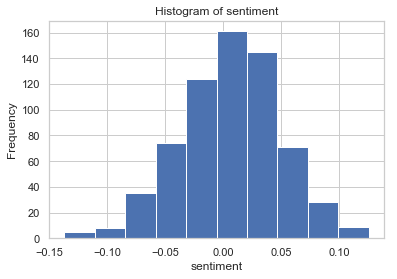

In [69]:
dataset.sentiment.hist()
plt.title('Histogram of sentiment')
plt.xlabel('sentiment')
plt.ylabel('Frequency')

I display some descriptive statistics of the sentiment analysis. I will further investigate the minimum value of the variable, -0.137.

In [70]:
dataset['sentiment'].describe()

count    660.000000
mean       0.006157
std        0.042987
min       -0.136929
25%       -0.022412
50%        0.007822
75%        0.034402
max        0.125828
Name: sentiment, dtype: float64

For illustrative purposes, I look for the most negative movie review in the test data. The worst review is the movie on index 166, which is called 'Shot Caller'. Not surprisingly, it is not a critics pick.  

In [72]:
x=dataset.sort_values(by='sentiment',ascending=True)
worst=x.head(1)
print(worst['display_title'])
print(worst['sentiment'])
print(worst['critics_pick'])
print(worst['url'])

166    Shot Caller
Name: display_title, dtype: object
166   -0.136929
Name: sentiment, dtype: float64
166    0
Name: critics_pick, dtype: int64
166    http://www.nytimes.com/2017/08/17/movies/shot-caller-review.html
Name: url, dtype: object


The review indicates the NYT critic does not like the movie at all. He calls the movie ludicrous at the end of the review. This provides additional evidence for the value of the sentiment analysis.

In [73]:
get_reviewtext('http://www.nytimes.com/2017/08/17/movies/shot-caller-review.html')

'“Shot Caller” is the third feature from Ric Roman Waugh (“Snitch,” “Felon”) to illustrate the notion that prisons make criminals instead of reforming them. Once a man is institutionalized, a character in “Shot Caller” says, “anything is possible.”\nTo prove that thesis, “Shot Caller” stretches “anything” well beyond credulity. Involving yet trivializing, the movie unfolds as a would-be “Breaking Bad” of the prison genre, following an inadvertent criminal who is hardened by a gangland behind bars and eventually becomes one of its cleverest members.\nBefore incarceration, Jacob Harlon (Nikolaj Coster-Waldau, from “Game of Thrones”) is a stockbroker from Pasadena. When he’s arrested after a fatal drunken-driving accident, concomitant charges and sentencing guidelines leave him in a bind that sends him to prison for far longer than he and his wife (Lake Bell) anticipated. Once there, he falls under the protection of a white-power gang; proves his cred by murdering a snitch; and meets the 

### Data preparation

The frequency table of the critics pick indicates that most movies are not recommended by the NYT critic. As a consequence, there is a class imbalance present.

In [74]:
dataset['critics_pick'].value_counts()

0    507
1    153
Name: critics_pick, dtype: int64

I upsample my training set in order to have an equal amount of critics picks and non critics picks. One of the dangers of having a large imbalance between the frequencies of the response binary variable, is that the algorithm will always predict the most frequent class. In this way, my algorithm can get an accuracy of 0.768, while it does not provide any insight in the data. 

In [75]:
train2=dataset

In [76]:
not_pick = train2[train2.critics_pick==0]
pick = train2[train2.critics_pick==1]

In [77]:
# upsample minority
pick_upsampled = resample(pick,
                          replace=True, # sample with replacement
                          n_samples=len(not_pick), # match number in majority class
                          random_state=99) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_pick, pick_upsampled])

# check new class counts
upsampled.critics_pick.value_counts()

1    507
0    507
Name: critics_pick, dtype: int64

### Feature engineering

In order to create features from the words, I will now apply the CountVectorizer on the training set. Notice that I use the training set in order to not bias the results, since some texts are copied. Further, the english stop words are excluded, since these words do not provide much analytical leverage. In addition, I only include the words that appear in more than 2% of the documents and in less than 80% of the documents. In this way I exclude corpus specific stop words. The lower bound excludes very rare words, which are dangerous for overfitting. I include unigrams and bigrams in the analysis. 

In [78]:
vectorizer = CountVectorizer(lowercase   = True,
                             ngram_range = (1,2),
                             max_df      = .80,
                             min_df      = .02,
                             stop_words   = 'english',
                             max_features = None)

In [79]:
vectorizer.fit(dataset['text'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.8, max_features=None, min_df=0.02,
        ngram_range=(1, 2), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [80]:
len(vectorizer.get_feature_names())

2044

I will now print some random feature names to check if the features are correctly created. The result demonstrates the countvectorizer performs well.

In [81]:
x=vectorizer.get_feature_names()
x[1950:1955]

['vulnerable', 'wade', 'wade crush', 'wait', 'waiting']

I now plot the most frequent words in the vectorizer. The large amount of 'mr' is not surprising since all these movies contain man in the title. Movie and film are respectively on the second and third place.

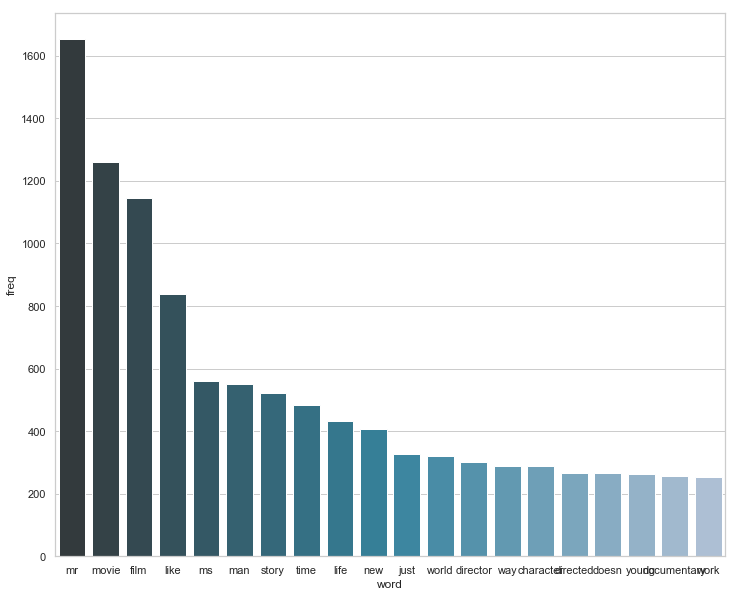

In [82]:
bow = vectorizer.fit_transform(train2['text'])
word_freq = dict(zip(vectorizer.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])
fig, ax = plt.subplots(figsize=(12, 10))
sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.show();

An alternative to excluding words is giving them smart weights. TF-IDF (term frequency-inverse document frequency) can be used to give a high weight to words that occur often in one or a couple documents, but do not often occur in many other documents. As a consequence, these words have a higer analytical leverage than words that occur in every document or only occur seldomly in a single document.

In [84]:
vectorizer= TfidfVectorizer(lowercase   = True,
                             ngram_range = (1,2),
                             max_features = None)

I fit the vectorizer on the original training data. Fitting the vectorizer on the oversampled dataset would have biased the results since some movies are cloned. Words in cloned movie reviews would have lower TF-IDF values. 

In [85]:
vectorizer.fit(dataset['text'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

The amount of features is very large, since I did not exclude words.

In [86]:
len(vectorizer.get_feature_names())

210544

I apply the vectorizer on the training set, oversampled training set and the test set.

In [87]:
vector_upsampled=vectorizer.transform(upsampled['text'])
vector_test=vectorizer.transform(testdata['text'])

In [88]:
vector_train=vectorizer.transform(dataset['text'])

### Logistic regression model

I first apply a classic logistic regression model on the upsampled data. For illustrative purposes, I first fitted the model on the original training data and next applied it on the test set. The logistic regression model predicted all critics picks wrongly as non critics pick. Hence, it is important to use the oversampled training data.

The logistic regression model of skikit-learn contains by default regularization. Hence, there is a lambda parameter that controls the complexity of the model to prevent overfitting. A small lambda results in a complexer model with large coefficients, while a large lambda develops a simpler model with small coefficients. I finetune this parameter with 10-fold crossvalidation in GridSearch.

In [89]:
pipeline = Pipeline([('classifier' , LogisticRegression(penalty = 'l2',random_state = 0))
                    ])

parameters = {'classifier__C' : [0.0000000001, 0.000000001, 0.0000001, 0.000001, 0.00001, 0.0001,0.001,0.01,0.1,1,10,15,20,30,40,50,60,70,80,90,100,200,500] }

In [90]:
grid_search = GridSearchCV(pipeline,
                           parameters,
                           n_jobs = -1,
                           cv = 10,
                           verbose = 1)

In [91]:
grid_search.fit(vector_upsampled,
                upsampled['critics_pick'])

Fitting 10 folds for each of 23 candidates, totalling 230 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:  1.3min finished
C:\Users\r0595384\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('classifier', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'classifier__C': [1e-10, 1e-09, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

The best cross-validation score is 0.9643. This model has a regularization parameter of 10. 

In [92]:
grid_search.best_score_

0.9694280078895463

In [93]:
grid_search.best_estimator_.get_params

<bound method Pipeline.get_params of Pipeline(memory=None,
     steps=[('classifier', LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])>

I will now fit the logistic regresion model again, but with the optimal regularization parameter, 10.

In [94]:
ln_classifier = LogisticRegression(penalty = 'l2', C = 10,random_state = 0)

In [95]:
ln_classifier.fit(vector_upsampled, upsampled['critics_pick'])

C:\Users\r0595384\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

The model is now evaluated on the oversampled training data. In order to do so, I first make a prediction. Next, I compute the accuracy and a classification report. The report and accuracy demonstrate I can predict my training data perfectly. 

In [96]:
 predict_upsampled=ln_classifier.predict(vector_upsampled)

In [97]:
print(accuracy_score(upsampled['critics_pick'],predict_upsampled))
print(classification_report(upsampled['critics_pick'],predict_upsampled))

1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       507
           1       1.00      1.00      1.00       507

   micro avg       1.00      1.00      1.00      1014
   macro avg       1.00      1.00      1.00      1014
weighted avg       1.00      1.00      1.00      1014



#### Evaluate the model on the test set

Now I predict the testdata and compute the accuracy and other evaluation metrics. In this way I can assess how good my model performs on new data and whether my model was overfitting or not. The accuracy is lower compared to the test set, but is still quite high. The drop can mainly be attributed to the lower precision and recall in the predictions of critics picks.

In [123]:
 predict_test=ln_classifier.predict(vector_test)

In [124]:
print(accuracy_score(testdata['critics_pick'],predict_test))
print(classification_report(testdata['critics_pick'],predict_test))

0.84375
              precision    recall  f1-score   support

           0       0.96      0.86      0.91       142
           1       0.39      0.72      0.51        18

   micro avg       0.84      0.84      0.84       160
   macro avg       0.68      0.79      0.71       160
weighted avg       0.90      0.84      0.86       160



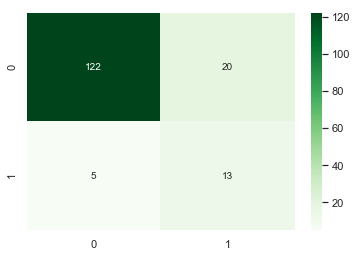

In [126]:
cm = confusion_matrix(testdata['critics_pick'], predict_test)
sns.heatmap(cm, annot=True, cmap="Greens", fmt='g', 
            yticklabels = ln_classifier.classes_,
            xticklabels =ln_classifier.classes_,)

### Nearest neighbor model

K-nearest neighbors is a method that predicts for a new instance the mode of his k neighbors. An important parameter is k, the number of neighbors. I will first finetune this parameter with crossvalidation. For the nearest neighbour model, I will not use the oversampled training set. The reason is that the model picks one as the optimal number of nearest neighbors. This is quite logical, since predicting the class of the nearest neighbor results in predicting the class of the clone in some cases. Hence, this will also bias the accuracy on the training data in a positive way. The reason is that the nearest neighbout is always the clone for the upsampled cases. As a consequence, I only use the training data.

10-fold cross-validation is performed to obtain the optimal number of neighbors. I search the optimal number of neigbors in a large range of possible parameters; the algorithms with 1 up to 30 neighbors are compared.

In [100]:
pipeline = Pipeline([('classifier' , KNeighborsClassifier())
                    ])

parameters = {'classifier__n_neighbors' : [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30] }

In [101]:
grid_search = GridSearchCV(pipeline,
                           parameters,
                           n_jobs = -1,
                           cv = 10,
                           verbose = 1)

In [102]:
grid_search.fit(vector_train, dataset['critics_pick'])

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   38.3s finished
C:\Users\r0595384\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('classifier', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'classifier__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

The model with the best crossvalidation score (0.65) predicts a new instance based on two neighbors.

In [103]:
print(grid_search.best_score_)
print(grid_search.best_estimator_.get_params)

0.65
<bound method Pipeline.get_params of Pipeline(memory=None,
     steps=[('classifier', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=2, p=2,
           weights='uniform'))])>


As an alternative to GridSearch, a loop is created that saves the results in a list.

In [104]:
 neighbours= list(range(1,30))

In [105]:
cv_scores = []
for k in neighbours:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, vectorizer.transform(train2['text']), train2['critics_pick'], cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

The results are displayed in a plot. The plot demonstrates that two is by far the best number of neighbors.

Text(0, 0.5, 'Accuracy')

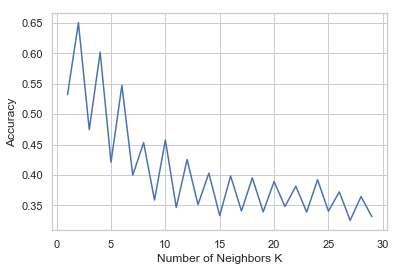

In [106]:
plt.plot(neighbours, cv_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Accuracy')

The algorithm is fitted again with the optimal number of neighbors. 

In [107]:
knn_classifier = KNeighborsClassifier(n_neighbors = 2)

In [108]:
knn_classifier.fit(vectorizer.transform(dataset['text']), dataset['critics_pick'])


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=2, p=2,
           weights='uniform')

Now the training data is predicted in order to evaluate the model.

In [109]:
knn_prediction = knn_classifier.predict(vectorizer.transform(dataset['text']))


The accuracy on the training is lower compared to the logistic regression model. Note that the measures are not exactly comparable; this algorithm is evaluated on the original training set. In contrast, logistic regression is evaluated on the oversampled training set. 

In [110]:
print(accuracy_score(dataset['critics_pick'], knn_prediction))
print(classification_report(dataset['critics_pick'], knn_prediction))


0.8803030303030303
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       507
           1       1.00      0.48      0.65       153

   micro avg       0.88      0.88      0.88       660
   macro avg       0.93      0.74      0.79       660
weighted avg       0.90      0.88      0.86       660



#### Evaluate model on test set

The algorithm predicts the test data.

In [120]:
knn_test_prediction = knn_classifier.predict(vector_test)


The accuracy on the test set is lower than the logistic regression model. In addition, the recall and precision in the prediction of critics picks is even lower than logistic regression. Hence, in this case the logistic regression model is superior to k-nearest neigbors.

In [121]:
print(accuracy_score(testdata['critics_pick'], knn_test_prediction ))
print(classification_report(testdata['critics_pick'], knn_test_prediction))


0.7125
              precision    recall  f1-score   support

           0       0.91      0.75      0.82       142
           1       0.18      0.44      0.26        18

   micro avg       0.71      0.71      0.71       160
   macro avg       0.55      0.60      0.54       160
weighted avg       0.83      0.71      0.76       160



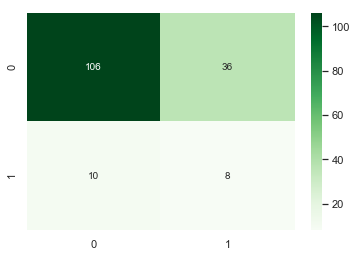

In [122]:
cm = confusion_matrix(testdata['critics_pick'], knn_test_prediction)
sns.heatmap(cm, annot=True, cmap="Greens", fmt='g', 
            yticklabels = knn_classifier.classes_,
            xticklabels =knn_classifier.classes_,)

### Multinomial naive bayes model


My last model is a multinomial naive bayes model. This model calculates probabilities of class membership by applying the Bayes theorem. The model makes a strong assumption: the value of a particular feature is independent of the value of any other feature, given the class variable. One can discuss whether the assumption holds in this data; it means that the presence or absence of a word is independent of the presence or absence of another word, given whether the movie is a critics pick or not. However, some literature suggest this algorithm works well when the assumption does not hold (e.g. Zhang H., The Optimality of Naive Bayes, AAAI 1, no. 2 (2004))

In [113]:
nb_classifier = MultinomialNB()

I fit the model and immediately make predictions of the upsampled training data.

In [114]:
nb_classifier.fit(vectorizer.transform(upsampled['text']), upsampled['critics_pick'])
nb_prediction = nb_classifier.predict(vectorizer.transform(upsampled['text']))

The accuracy on the upsampled training set is quite high, the accuracy equals 0.998. Still, this is a little bit lower lower than the logistic regression model.  

In [115]:
print(accuracy_score(upsampled['critics_pick'], nb_prediction))
print(classification_report(upsampled['critics_pick'], nb_prediction))

0.9980276134122288
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       507
           1       1.00      1.00      1.00       507

   micro avg       1.00      1.00      1.00      1014
   macro avg       1.00      1.00      1.00      1014
weighted avg       1.00      1.00      1.00      1014



#### Evaluate model on test set

Now the algorithm makes predictions for the test data.

In [116]:
predict_test=nb_classifier.predict(vector_test)

The accuracy on the test set demonstrates that this model performs worse than the logistic regression model. Still, the recall on the critics picks equals one, which is higher than the logistic regression model. This indicates that the model does not predict any non critics pick as a critic pick. Equivalently, the precision of the non critics picks equals one. Suppose that the misclassification costs would be unequal, with a higher cost predicting a non critics pick as a critic pick, this model would be preferred. However, in this case the misclassification costs are equal.

In [117]:
print(accuracy_score(testdata['critics_pick'], predict_test))
print(classification_report(testdata['critics_pick'], predict_test))

0.41875
              precision    recall  f1-score   support

           0       1.00      0.35      0.51       142
           1       0.16      1.00      0.28        18

   micro avg       0.42      0.42      0.42       160
   macro avg       0.58      0.67      0.40       160
weighted avg       0.91      0.42      0.49       160



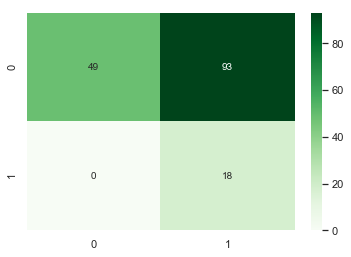

In [119]:
cm = confusion_matrix(testdata['critics_pick'], predict_test)
sns.heatmap(cm, annot=True, cmap="Greens", fmt='g', 
            yticklabels = nb_classifier.classes_,
            xticklabels =nb_classifier.classes_,)

### Conclusion

To conclude, logistic regression makes good predictions whether the critic recommends the movie or not based on the words in the movie reviews. The accuracy of the model on new data equals 0.84375. This is higher than the k-nearest neighbors and multinomial naive bayes algorithms.  